# RNN USE
I denne notebooken tar jeg i bruk den modellen jeg har lagd tidligere

In [281]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens
from lib.create_dataset import create_dataset

In [371]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_15_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma15_derivert'] = [stock.open_15_sma[i] / stock.open_15_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_15_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        stocks.append(stock)
    
    return stocks

def prepare_evaluate_trade(prediction):
    # Setter indeks til hver for å få riktig.. Litt tungvindt
    where_are_NaNs = np.isnan(prediction) #Byttet NaN til 1
    prediction[where_are_NaNs] = 1
    
    dict_pred = {}
    
    for i, pred in enumerate(prediction):
        for j, v in enumerate(pred):
            if i+j not in dict_pred:
                dict_pred[i+j] = [v]
            else:
                dict_pred[i+j].append(v)
    
    
    df_pred = pd.DataFrame(columns=['tid','verdier','avg'])
    df_pred.tid = list(dict_pred.keys())
    df_pred.verdier = list(dict_pred.values())
    df_pred.avg = [sum(l)/len(l) for l in list(dict_pred.values())]
    
    return df_pred


def evaluate_trade(data, df_pred, prediciton, look_forward):
    
    fig, ax1 = plt.subplots()
    #for i,v in enumerate(prediciton):
    #    ax1.plot(range(i+30, i+30+len(v)), v, color='red')
        
    p1, = ax1.plot(range(30, len(df_pred.avg)+30), df_pred.avg, color='red', label='avg_pred')
    ax1.set_ylabel('30sma_prediction')
    ax1.yaxis.label.set_color('red')
    
    ax2 = ax1.twinx()
    p2, = ax2.plot(data.open, color='blue', label='true_price')
    ax2.set_ylabel('True price')
    ax2.yaxis.label.set_color('blue')
    
    # If df_pred.avg is big enough then buy
    forslag = ['0_selg']*21
    bytteix = pd.DataFrame(columns=['kjøp', 'selg', 'pris_kjøp', 'pris_salg', 'gevinst','ac_sum'])
    bytteix_buy = []
    bytteix_sell = []
    bytteswitch = True
    bytte_ac_sum = []
    ac_sum = 0
    for ix,pred in enumerate(df_pred.avg):
        if ix>0:
            if pred>0:
                ac_sum += pred
            else:
                ac_sum = 0

            if pred > 1 or ac_sum > 15:
                forslag.append('1_kjøp')
                if bytteswitch:
                    bytte_ac_sum.append(ac_sum)
                    bytteix_buy.append(ix+20)
                    bytteswitch = False

            else:
                forslag.append('0_selg')
                if not bytteswitch:
                    bytteix_sell.append(ix+20)
                    bytteswitch = True
    
    bytteix.kjøp = bytteix_buy
    bytteix.selg = bytteix_sell
    bytteix.ac_sum = bytte_ac_sum
    
    gevinst = []
    pris_kjøp = []
    pris_salg = []
    for i, row in bytteix.iterrows():
        buy = data.open[row.kjøp]
        sell = data.open[row.selg]
        gevinst.append(100*sell/buy)
        pris_kjøp.append(data.open[row.kjøp])
        pris_salg.append(data.open[row.selg])
    
    bytteix.gevinst = gevinst
    bytteix.pris_kjøp = pris_kjøp
    bytteix.pris_salg = pris_salg
        
    
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    p3, = ax3.plot(forslag, color='green')
    ax3.set_ylabel('forslag axes')
    ax3.yaxis.label.set_color('green')
    
    lines = [p1, p2]
    plt.legend(lines, [l.get_label() for l in lines])
    
    plt.show()
    
    print(bytteix)
    

    
def add_data(word):
    ordet = 'data/' + word
    return ordet


In [368]:
filer = list(map(add_data, os.listdir('data/')))[60:70] # test 54:60
data = make_ready(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [369]:
dataxes = []
datayes = []
sanne = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay, sann = create_dataset().create(
                                  one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.append(datax)
    datayes.append(datay)
    sanne.append(sann)

In [6]:
model = keras.models.load_model('models/rnn_model.h5')

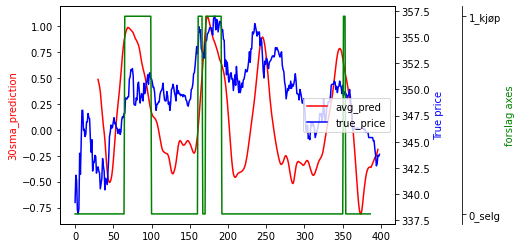

   kjøp  selg  pris_kjøp  pris_salg     gevinst     ac_sum
0    65   100      347.7      351.0  100.949094  15.705800
1   161   167      354.0      353.5   99.858757   5.695568
2   171   192      354.6      355.6  100.282008  15.664171
3   351   354      349.4      349.6  100.057241  15.072007


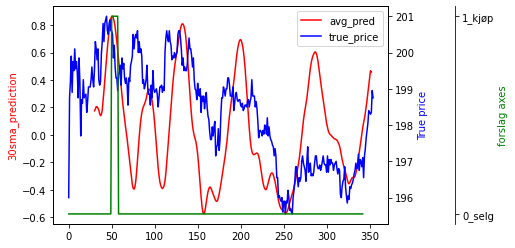

   kjøp  selg  pris_kjøp  pris_salg    gevinst     ac_sum
0    50    58      200.6      199.4  99.401795  15.027725


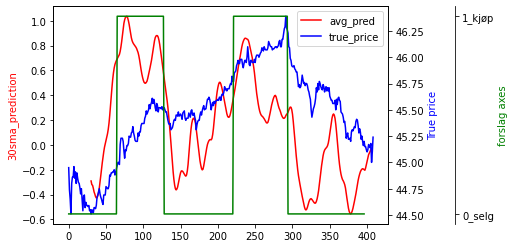

   kjøp  selg  pris_kjøp  pris_salg     gevinst     ac_sum
0    65   128      44.97      45.52  101.223038  14.636743
1   221   294      45.77      46.23  101.005025  15.741661


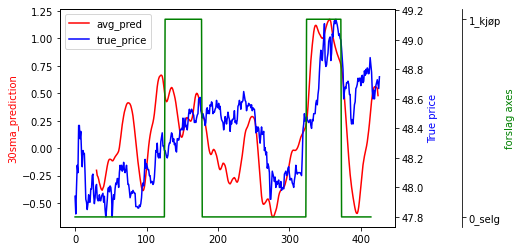

   kjøp  selg  pris_kjøp  pris_salg     gevinst     ac_sum
0   126   178      48.25      48.47  100.455959  15.032628
1   324   373      48.48      48.94  100.948845   8.721278


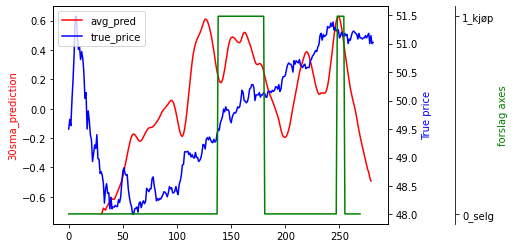

   kjøp  selg  pris_kjøp  pris_salg     gevinst     ac_sum
0   138   181      49.50      50.12  101.252525  15.007209
1   248   255      51.24      51.18   99.882904  15.165220


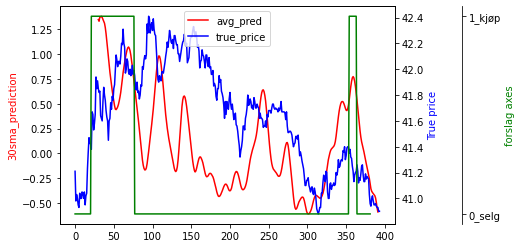

   kjøp  selg  pris_kjøp  pris_salg     gevinst     ac_sum
0    21    77      41.38      41.95  101.377477   1.329413
1   354   364      41.35      41.26   99.782346  15.138567


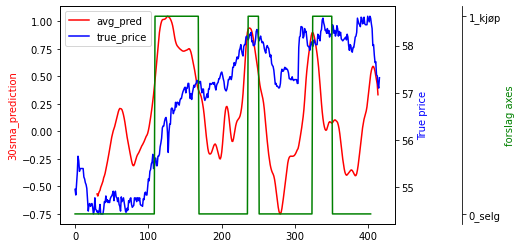

   kjøp  selg  pris_kjøp  pris_salg     gevinst     ac_sum
0   109   169      55.62      57.20  102.840705  10.389388
1   236   251      58.12      58.10   99.965588  15.378925
2   324   351      57.98      58.44  100.793377  15.386016


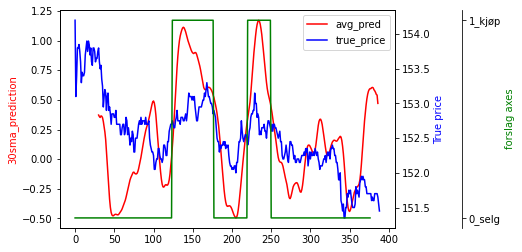

   kjøp  selg  pris_kjøp  pris_salg     gevinst    ac_sum
0   124   177     152.75      152.9  100.098200  6.879361
1   220   250     152.40      152.6  100.131234  8.164496


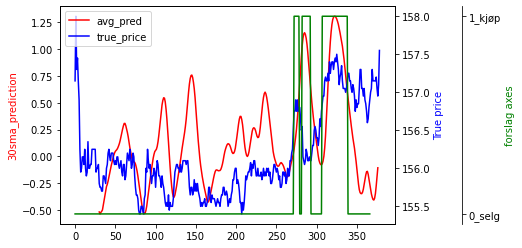

   kjøp  selg  pris_kjøp  pris_salg     gevinst     ac_sum
0   272   279     156.75     156.80  100.031898   5.429849
1   282   293     156.55     156.10   99.712552  15.433620
2   307   339     156.85     157.25  100.255021   4.551968


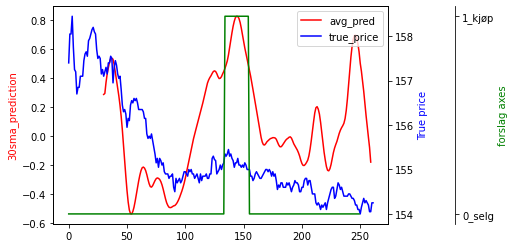

   kjøp  selg  pris_kjøp  pris_salg    gevinst     ac_sum
0   134   155     155.35      155.0  99.774702  15.411979


In [372]:
for i,stockdata in enumerate(data):
    prediciton = model.predict(dataxes[i])
    df_pred = prepare_evaluate_trade(prediciton)
    evaluate_trade(stockdata, df_pred, prediciton, look_forward)

In [333]:
df_pred

,tid,verdier,avg
0,0,[1.0],1.000000
1,1,"[1.0, -0.03304274]",0.483479
2,2,"[1.0, -0.077676564, -0.070980646]",0.283781
3,3,"[1.0, -0.053049, -0.11929916, -0.09770004]",0.182488
4,4,"[1.0, -0.070169635, -0.10113522, -0.14998336, ...",0.118277
...,...,...,...
325,325,"[0.0002685776, -0.059146624, -0.048997708, 0.0...",-0.004114
326,326,"[0.019175678, -0.03193757, 0.020856429, 0.0873...",0.023867
327,327,"[0.043075617, 0.041563805, 0.08628017]",0.056973
328,328,"[0.113419764, 0.113912866]",0.113666


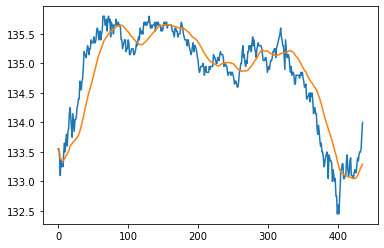

In [69]:
plt.plot(data[0].open)
plt.plot(data[0].open_30_sma)

In [143]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,133.55,133.55,133.55,133.55,77319,77319,NaN,NaN,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
1,9:1,133.55,133.55,133.55,133.55,13845,13845,133.55,0.00,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
2,9:2,133.40,133.40,133.40,133.40,29772,29772,133.55,-0.15,0.000000,...,133.500000,-0.004651,-0.001906,-0.002745,133.500000,133.500000,0.000000,0.999626,0.999626,0.998877
3,9:3,133.10,133.10,133.10,133.10,14807,14807,133.40,-0.30,0.000000,...,133.400000,-0.017484,-0.007183,-0.010301,133.400000,133.400000,0.000000,0.999251,0.999251,0.997751
4,9:4,133.35,133.35,133.35,133.35,13958,13958,133.10,0.25,0.594707,...,133.390000,-0.014142,-0.009253,-0.004888,133.390000,133.390000,0.000000,0.999925,0.999925,1.001878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,16:16,133.50,133.50,133.50,133.50,12738,12738,133.45,0.05,1.274000,...,133.243750,0.060187,0.021415,0.038772,133.195000,133.250000,0.068750,1.000263,1.000175,1.000375
432,16:17,133.50,133.50,133.50,133.50,33641,33641,133.50,0.00,1.274000,...,133.265625,0.071448,0.031421,0.040027,133.223333,133.260000,0.084375,1.000213,1.000075,1.000000
433,16:18,133.55,133.55,133.55,133.55,12709,12709,133.50,0.05,1.336942,...,133.278125,0.083446,0.041826,0.041619,133.245000,133.270000,0.121875,1.000163,1.000075,1.000375
434,16:19,133.80,133.80,133.80,133.80,17495,17495,133.55,0.25,1.668213,...,133.303125,0.111837,0.055828,0.056009,133.265000,133.316667,0.178125,1.000150,1.000350,1.001872
